# PCA on a Laptop

## Introduction

It should have been called PCA on a laptop shape, but you can run PCA on a laptop as well...

During the lectures, a demonstration was given of PCA, when applied to a laptop. A laptop in space is 3D, but can be approximated by a 2D shape. The problem is how to project out the third dimension.

## Learning Objectives

In earlier notebooks, we established that symmetric matrices in $N$ dimensions have $N$ eigenvectors, which are orthogonal. 
Moreover, for a covariance matrix, the eigenvalues are non-negative. The claim is that the eigenvectors form a new
basis that can be used to represent the data. In this basis, each of the new axes correspond to an eigenvector and therefore characterise the principal directions of the data (which we will demonstrate below).

In this  notebook we will see that:

- eigenvectors of a covariance matrix form a basis
- principal directions in the data correspond to eigenvectors of the covariance matrix
- by performing a basis transformation, the principal directions of the data now correspond to the principal axes($x$, $y$, $z$, ...)
- data can be reduced by simply ignoring axes that don't carry much data variability
- transforming back to the original basis, you will obtain a dataset that looks like the original one, but flat in some directions; these directions are determined by the dataset.
- this achieves data reduction

## Learning Outcome

At the end of this notebook, should be able to go through all steps that are involved in principal component analysis.

 

## A synthetic dataset

My laptop measures $40 \times 15 \times 1$ cm. I can simulate a sample of $N$ data points, using techniques I have already seen. Then I will rotate and translate the data by arbitrary amounts and I will show the resulting dataset.  This is a synthetic dataset: one that simulates a dataset that could have been given us in practice, where we don't have any information but the position and orientation of the data.

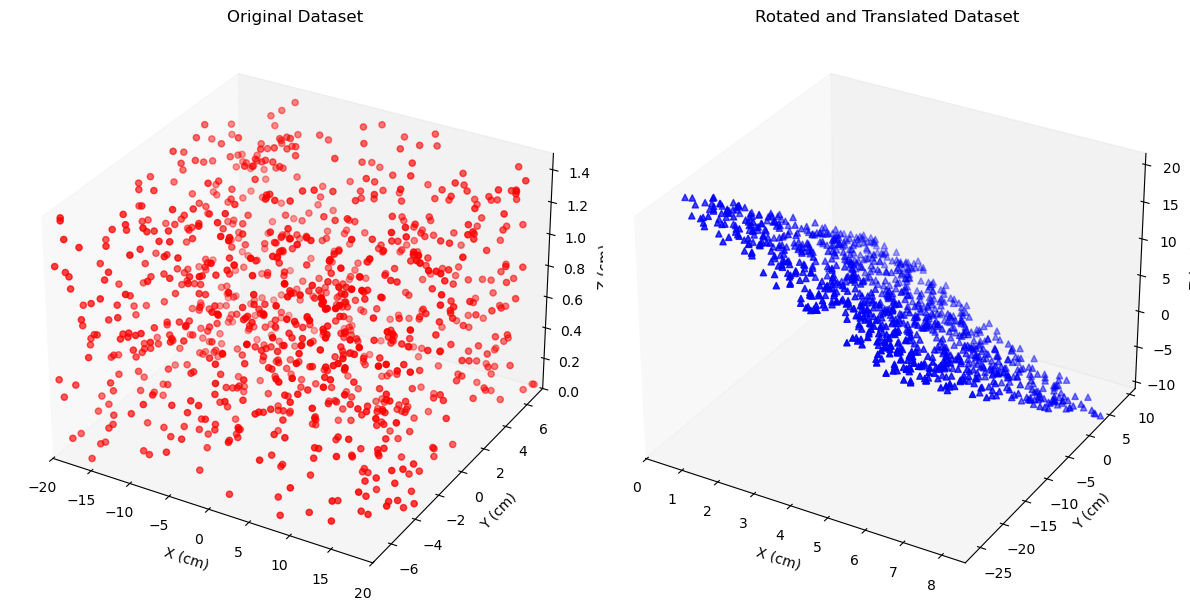

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.stats import uniform
import matplotlib.pyplot as plt

# Set the seed explicitly at the start
seed = 42
rng = np.random.default_rng(seed)

# Function to generate, rotate, and translate points
def generate_rotate_translate_points(x_range, y_range, z_range, n_points=100):
    # Step 1: Generate random points in the specified ranges using object-based random generator interface
    x = uniform(loc=-x_range, scale=2*x_range).rvs(size=n_points, random_state=rng)  # x between -x_range and x_range cm
    y = uniform(loc=-y_range, scale=2*y_range).rvs(size=n_points, random_state=rng)  # y between -y_range and y_range cm
    z = uniform(loc=0, scale=z_range).rvs(size=n_points, random_state=rng)  # z between 0 and z_range cm
    
    # Combine them into an (n_points, 3) array
    points = np.vstack((x, y, z)).T
    
    # Step 2: Generate three random Euler angles for rotation
    euler_angles = rng.uniform(0, 2*np.pi, 3)  # Three random angles in radians
    
    # Step 3: Apply rotation using scipy's Rotation object
    rotation = R.from_euler('xyz', euler_angles)
    rotated_points = rotation.apply(points)
    
    # Step 4: Apply a random translation
    translation_vector = rng.uniform(-10, 10, 3)  # Random translation vector between -10 and 10 cm
    translated_points = rotated_points + translation_vector
    
    # Return the original and translated points
    return points, translated_points

# Customize the range values for x, y, and z
x_range = 20
y_range = 7.5
z_range = 1.5

# Call the function to generate, rotate, translate, and return the points
original_points, transformed_points = generate_rotate_translate_points(x_range, y_range, z_range, n_points=1000)

# Step 5: Plot the original and transformed points in 3D

# Plot original points
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(original_points[:, 0], original_points[:, 1], original_points[:, 2], c='r', marker='o')
ax1.set_title('Original Dataset')
ax1.set_xlabel('X (cm)')
ax1.set_ylabel('Y (cm)')
ax1.set_zlabel('Z (cm)')
ax1.set_xlim([-x_range, x_range])
ax1.set_ylim([-y_range, y_range])
ax1.set_zlim([0, z_range])
ax1.grid(False)  # Disable grid

# Plot transformed points
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(transformed_points[:, 0], transformed_points[:, 1], transformed_points[:, 2], c='b', marker='^')
ax2.set_title('Rotated and Translated Dataset')
ax2.set_xlabel('X (cm)')
ax2.set_ylabel('Y (cm)')
ax2.set_zlabel('Z (cm)')

# Set dynamic axis limits based on transformed points
x_limits = (transformed_points[:, 0].min(), transformed_points[:, 0].max())
y_limits = (transformed_points[:, 1].min(), transformed_points[:, 1].max())
z_limits = (transformed_points[:, 2].min(), transformed_points[:, 2].max())

ax2.set_xlim(x_limits)
ax2.set_ylim(y_limits)
ax2.set_zlim(z_limits)
ax2.grid(False)  # Disable grid

plt.tight_layout()
plt.show()


## PCA: reduction from 3D to 2D

Consider the rotated and translated dataset as something that was given to us by a third party. We have no idea how it was generated.
The shape looks a bit flat. We might try to compress the data by getting rid of the 'thickness', but we need to find out how the data is aligned first. To simply things we first centre the data.

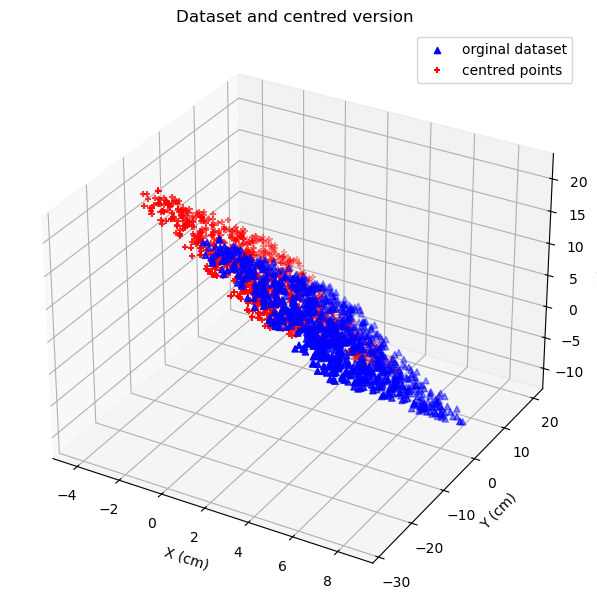

In [2]:
mu =  np.mean(transformed_points, axis = 0)
centered_points = transformed_points - mu

# Plot original points
fig10 = plt.figure(figsize=(12, 6))

# Plot transformed points
ax10 = fig10.add_subplot(121, projection='3d')
ax10.scatter(transformed_points[:, 0], transformed_points[:, 1], transformed_points[:, 2], c='b', marker='^',label = 'orginal dataset')
# Plot centered points
ax10.scatter(centered_points[:, 0], centered_points[:, 1], transformed_points[:, 2], c='r', marker='+', label = 'centred points')
ax10.set_title('Dataset and centred version')
ax10.set_xlabel('X (cm)')
ax10.set_ylabel('Y (cm)')
ax10.set_zlabel('Z (cm)')

plt.legend()
plt.tight_layout()
plt.show()


## Covariance matrix of an arbitrary dataset

We can do maximum likelihood estimation of the covariance matrix of the data. The covaraince matrix treats the data as it were generated from a Gaussian distriibution, which is not. We're doing it anyway.

(3, 3)


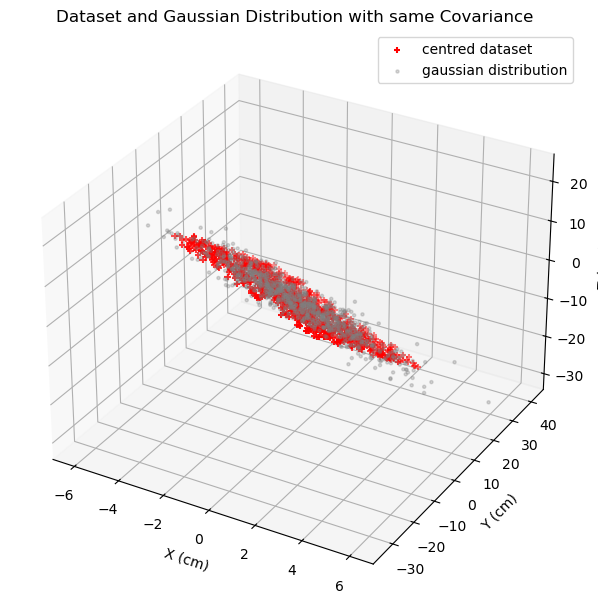

In [3]:
# Plot original points
fig11 = plt.figure(figsize=(12, 6))

# Plot transformed points
ax11 = fig11.add_subplot(121, projection='3d')
# Plot centered points
ax11.scatter(centered_points[:, 0], centered_points[:, 1], centered_points[:, 2], c='r', marker='+', label = 'centred dataset')

# estimate the covariance matrix, using maximum likelihood
estimated_covariance = np.cov(centered_points.T)
print(estimated_covariance.shape)

# for comparison, plot points sampled from a Gaussian distibution
def sample_gaussian_points(N, mu, cov, rng):
    # Sample N points from a multivariate Gaussian distribution
    samples = rng.multivariate_normal(mean=mu, cov=cov, size=N)
    return samples

gauss_points = sample_gaussian_points(1000, (0. , 0.,  0.), estimated_covariance, rng)

# plot them over the data set
ax11.scatter(gauss_points[:, 0], gauss_points[:, 1], gauss_points[:, 2], c='grey', marker='.',alpha = 0.3, label = 'gaussian distribution')
plt.legend()
plt.tight_layout()
ax11.set_title('Dataset and Gaussian Distribution with same Covariance')
ax11.set_xlabel('X (cm)')
ax11.set_ylabel('Y (cm)')
ax11.set_zlabel('Z (cm)')

plt.show()



## Extracting the principal directions.

The Guassian data points clear don't match the laptop shape. This dataset is non Gaussian, so that is not a surprise. The principal directions of the dataset correspond very well though!  Essentially we use the Gaussian to model the directions of the data, not the data itself.  Let's find these directions:

In [4]:
eigs = np.linalg.eig(estimated_covariance)
print(eigs)

EigResult(eigenvalues=array([  0.1885203 ,  18.83689734, 136.03560458]), eigenvectors=array([[-0.88806871, -0.45891703, -0.02700232],
       [-0.23634108,  0.50615592, -0.82942696],
       [-0.39430554,  0.73020637,  0.55796218]]))


Let's visualize these directions on the dataset.

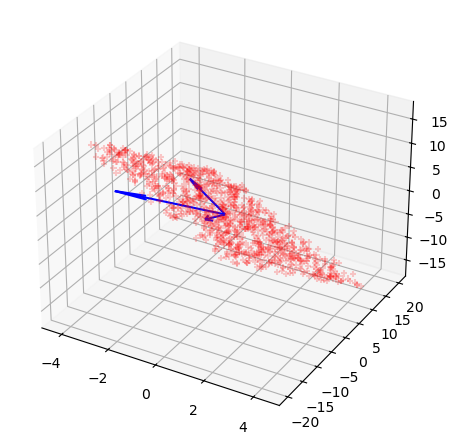

In [5]:
fig12 = plt.figure(figsize=(12, 6))

# Plot transformed points
ax12 = fig12.add_subplot(121, projection='3d')
# Plot centered points
ax12.scatter(centered_points[:, 0], centered_points[:, 1], centered_points[:, 2], c='r', marker='+',alpha = 0.2)

eigs = np.linalg.eig(estimated_covariance)
eig0 = eigs.eigenvectors[0]
eig1 = eigs.eigenvectors[1]
eig2 = eigs.eigenvectors[2]

# Plot the direction vector as an arrow starting at the origin
ax12.quiver(0, 0, 0, eig0[0], eig0[1], eig0[2], color='b', length=5.0, normalize=False)
ax12.quiver(0, 0, 0, eig1[0], eig1[1], eig1[2], color='b', length=5.0, normalize=False)
ax12.quiver(0, 0, 0, eig2[0], eig2[1], eig2[2], color='b', length=5.0, normalize=False)




The directions of the eigenvectors have been drawn with arbitrary length here. But the directions seem to match the data really well.

## Basis Transformations.

The standard basis in $\mathbb{R}^2$ are given by vectors $\vec{e}_1 = (1, 0)^T$ and $\vec{e}_2 = (0, 1)^T$. Any vector $\vec{v}$ can be identified in terms of components with respect to this basis. $\vec{v} = v_1 \vec{e}_1 + v_2 \vec{e}_2$:
$$
v = \left( \begin{array}{c} v_1 \\ v_2 \end{array} \right)
$$

I don't have to use the standard basis. I can use basis $\vec{f}_1 = (1,1)^T$ and $\vec{f}_2 = (1, -1)^T$.  I can represent the same vector $\vec{v}$, but the numerical components will be different. This is demonstrated in the figure below, where the vector $v$ is decomposed into components with respect to the $\vec{e}$ and $\vec{f}$ bases.

An natural and important question is then: given a vector $\vec{v} = v_1 \vec{e}_1 + v_2 \vec{e}_2$, with known components $(v_1, v_2)^T$,
what are the components with respect to a given basis $\{ \vec{f}_1, \vec{f}_2 )\}$.

![Alt text](decomp.png)

**Exercise**: In the plot below, what are the compenents of the black vector $\vec{v}$ with respect to the $\vec{e}$ and $\vec{f}$ basis?


## Basis Transformations using Matrices

Assume I have been given a set of two vectors $\left\{ \vec{f}_1, \vec{f}_2 \right\}$. What is a convenient way to implement a map
from the standard basis $\left\{ \vec{e}_1, \vec{e}_2 \right\}$ to the $f$-basis? By definition, this is just the set of vectors 
$\left\{ \vec{f}_1, \vec{f}_2 \right\}$, organised as a matrix.

For example, the matrix 
$$
\mathcal{F} = \left( \begin{array}{cc} 1 & 1 \\ 1 & -1 \end{array} \right)
$$
maps $(1 , 0)^T$ to $(1, 1)^T$ and $(0, 1)^T$ to $(1, -1)^T$.

For a given vector $\vec{v}$ with components $(v_1, v_2)^T$ given with respect to the $\vec{e}$-basis, we can now answer the question:
'what are the components with respect to the $\vec{f}$-basis?'.

We need to find $w_1$, $w_2$ such that:
$$
w_1 \vec{f_1} + w_2 \vec{f_2}  = v_1 \vec{e}_1 + v_2 \vec{e}_2
$$
Writing this out in terms of the components of matrix $\mathcal{F}$ one finds:
$$
w_1(f_{11}\vec{e}_1 + f_{12}\vec{e}_2) + w_2(f_{21}\vec{e}_1 + f_{22}\vec{e}_2) = v_1 \vec{e}_1 + v_2 \vec{e}_2.
$$
Reorganising:
$$
(w_1f_{11} + w_2f_{21})\vec{e}_1 +(w_1f_{12} + w_2f_{22})e_2 = v_1 \vec{e}_1 + v_2 \vec{e}_2
$$
In matrix vector notation this can be written as:
$$
\mathcal{F}^T\vec{w} = \vec{v},
$$
so that:
$$
\vec{w} = (\mathcal{F}^T)^{-1} \vec{v}
$$
We could leave it at that, because *numpy* offers simple methods simple methods to transpose or invert matrices. However, $\mathcal{F}$
is a so-called *orthonormal* matrix (all columns are perpendicular and have length one), and one can show that for such matrices
$$
\mathcal{F}^T = \mathcal{F}^{-1}
$$
so that, ultimately:
$$
\vec{w} = \mathcal{F} \vec{v}
$$

In words, this means that if we take a data point in the standard basis, and apply the matrix of eigenvectors to it, we get the data point expressed in the eigenbasis. Let's do this.

(1000, 3)


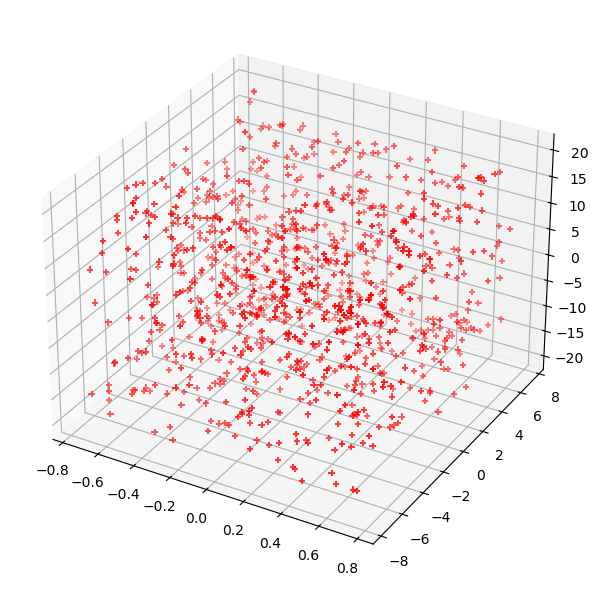

In [6]:
fig13 = plt.figure(figsize=(12, 6))

f=eigs.eigenvectors

# this is a bit convoluted, the goal is to apply f to each data point individually
# and to work correctly, we would have a single data point as column vector, so shape  (3, 1)
# however, we have a 1000 data points in an array of shape 1000, 3:
print(centered_points.shape)
# python allows broadcasting to to matrix multiplication in parallel, but to multiply a matrix of shape 3 x3 with
# an array of shape 1000, 3 we need to transpose it to an array of shape 3, 1000, and since the data is transposed,
# the matrix of eigenvector needs to be transposed

centered_in_eigen_base = f.T.dot(centered_points.T).T

# Plot transformed points
ax13 = fig13.add_subplot(121, projection='3d')
# Plot centered points
ax13.scatter(centered_in_eigen_base[:, 0], centered_in_eigen_base[:, 1], centered_in_eigen_base[:, 2], c='r', marker='+')
plt.tight_layout()
plt.show()


The choice of axis limits makes the data seem cubic, but in reality it's quite flat, which becomes apparent if
all axis are given equal limits:

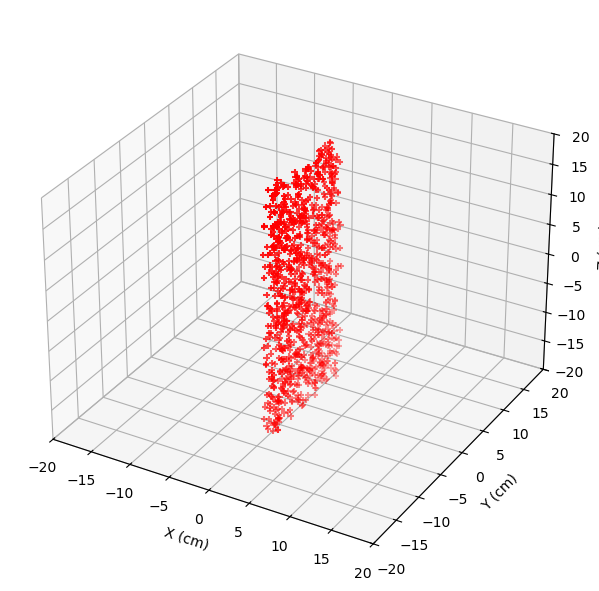

In [7]:
fig14 = plt.figure(figsize=(12, 6))

# Plot transformed points
ax14 = fig14.add_subplot(121, projection='3d')
ax14.set_xlim([-20., 20.])
ax14.set_ylim([-20., 20.])
ax14.set_zlim([-20., 20.])

ax14.scatter(centered_in_eigen_base[:, 0], centered_in_eigen_base[:, 1], centered_in_eigen_base[:, 2], c='r', marker='+')
ax14.set_xlabel('X (cm)')
ax14.set_ylabel('Y (cm)')
ax14.set_zlabel('Z (cm)')

plt.tight_layout()
plt.show()


## The Idea of Principal Component Analysis

The idea of principal component analysis, is to simply throw away the data components which have the least variance. We find this not by visual inspection but by looking at the size of the eigenvalues:

In [8]:
eigenvalues = eigs.eigenvalues
print(eigenvalues)

print('Eigenvalue 0 carries a fraction of ',  eigenvalues[0]/np.sum(eigenvalues), 'of the data variance.')
print('Eigenvalue 1 carries a fraction of ',  eigenvalues[1]/np.sum(eigenvalues), 'of the data variance.')
print('Eigenvalue 2 carries a fraction of ',  eigenvalues[2]/np.sum(eigenvalues), 'of the data variance.')

[  0.1885203   18.83689734 136.03560458]
Eigenvalue 0 carries a fraction of  0.0012157813739393211 of the data variance.
Eigenvalue 1 carries a fraction of  0.12148054406856398 of the data variance.
Eigenvalue 2 carries a fraction of  0.8773036745574967 of the data variance.


Based on these numbers, it seems we can reduce the dataset to a two dimensional one by getting rid of the $x$-coordinate. This is obvious if we look at the scatterplot above, but bear in mind that we usually cannot visualize high dimensional datasets. **In general we 
keep the dimensions that carry a certain percentage of the variance in the dataset and remove the dimensions that do not contribute to that fraction.** In this case the $x$-coordinate.

In [9]:
# reduce the dataset by slicing off the first column
reduced_dataset = centered_in_eigen_base[:, 1:]
print(reduced_dataset.shape)

(1000, 2)


The reduced dataset can now be stored on disk and is obviously reduced in size. You also need to store the eigenvector matrix in order to be able to restore the data in its original orientation.

## Projecting the reduced dataset back to original coordinates

In general, you need to transfer the original data back to the original frame in order to be able to benefit from the data reduction.
You then need to restore the full dimensionality of the reduced dataset by adding zeros to replace the deleted data.

In [10]:
n_events = reduced_dataset.shape[0]

# Create a column of zeros
zeros_column = np.zeros((1000, 1))

reduced_but_full_dimension = np.hstack((zeros_column,reduced_dataset))
print(reduced_but_full_dimension.shape)




(1000, 3)


We will project this back and show a comparison with the original dataset. The projection is simply done by applying
the inverse matrix of the eigenvectors.

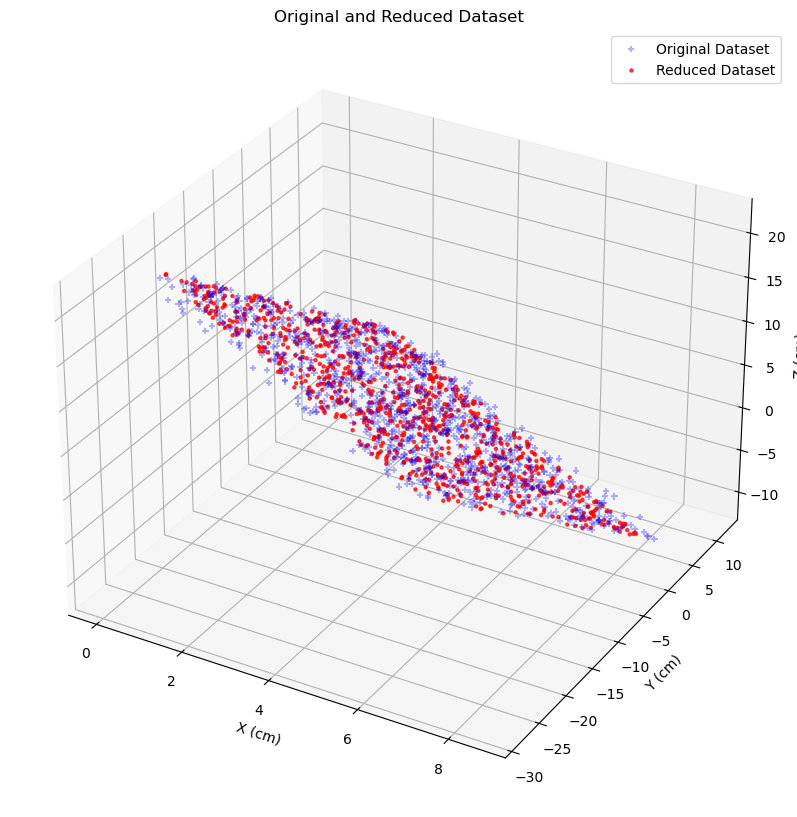

In [11]:
finv=np.linalg.inv(eigs.eigenvectors) # this is a straightforward but inefficient way to do this, see remarks
                                      # below about how to invert a rotation matrix.

# this implements the inverse transformation. don't forget to add the original offset
reduced_centered_in_eigen_base = finv.T.dot(reduced_but_full_dimension.T).T + mu


fig20 = plt.figure(figsize=(16, 16))

# Plot the original dataset, which is stored in transformed_points
ax20 = fig20.add_subplot(121, projection='3d')
ax20.scatter(transformed_points[:, 0], transformed_points[:, 1], transformed_points[:, 2], c='b', marker='+', alpha = 0.3,label='Original Dataset')

# Plot the back project reduced dataset
ax20.scatter(reduced_centered_in_eigen_base[:, 0], reduced_centered_in_eigen_base[:, 1], reduced_centered_in_eigen_base[:, 2], c='r', marker='.', alpha = 0.7,label='Reduced Dataset')

ax20.set_title('Original and Reduced Dataset')
ax20.set_xlabel('X (cm)')
ax20.set_ylabel('Y (cm)')
ax20.set_zlabel('Z (cm)')

# Set dynamic axis limits based on transformed points
x_limits = (transformed_points[:, 0].min(), transformed_points[:, 0].max())
y_limits = (transformed_points[:, 1].min(), transformed_points[:, 1].max())
z_limits = (transformed_points[:, 2].min(), transformed_points[:, 2].max())

plt.legend()
plt.tight_layout()
plt.show()



The reduced dataset is flatter than the original one. The flattening has been done with respect to axes defined by the original dataset, not to arbitrary ones.

## Conclusions
This example shows the geometry of PCA, but do bear in mind that usually the dimensionality of the dataset is much larger, which allows you to achieve much better compression rations, 2/3 is not that impressive. Nonetheless, the entire machinery is exactly the same as shown here.